In [1]:
import numpy as np 
import math 
import pandas as pd 
pd.set_option('display.float_format',lambda x:'%.3f' % x)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns 
sns.set_palette('muted')
sns.set_style('darkgrid')
sns.set(font='SimHei')
import warnings
warnings.filterwarnings('ignore')
path = 'C:/test/work/ppd/data'
import lightgbm as lgb 
from lightgbm import plot_importance

In [2]:
# 导入feature_processing处理过后的数据
data = pd.read_csv(path+'/data1_process.csv',encoding='gb18030')
periods_df = pd.read_csv(path+'/periods_feature.csv',encoding='gbk')
rank_df = pd.read_csv(path+'/rank_feature.csv',encoding='gbk')
update_info = pd.read_csv(path+'/update_feature.csv',encoding='gbk')
log_df = pd.read_csv(path+'/log_info_feature.csv',encoding='gbk')

In [3]:
# 合并衍生后的变量，data1不包含排序特征和periods衍生特征
data1 = pd.merge(data,update_info,on='Idx',how='left')
data1 = pd.merge(data1,log_df,on='Idx',how='left')
data1.shape

(49101, 242)

In [4]:
# data2包含排序特征和periods衍生特征
data2 = pd.concat([data1,rank_df,periods_df],axis=1)
data2.shape

(49101, 430)

In [5]:
data_idx = data.Idx
df1  =data1.drop(['Idx'],axis=1)# 删除Idx
# 测试集训练集的划分
train_fea = np.array(df1[df1.sample_status=='train'].drop(['sample_status','target'],axis=1))
test_fea = np.array(df1[df1.sample_status=='test'].drop(['sample_status','target'],axis=1))
train_label = np.array(df1[df1.sample_status=='train']['target']).reshape(-1,1)
test_label = np.array(df1[df1.sample_status=='test']['target']).reshape(-1,1)


fea_names = list(df1.drop(['sample_status','target'],axis=1).columns)# 特征名字存成列表
feature_importance_values = np.zeros(len(fea_names)) # 

# 训练10个lightgbm，并对10个模型输出的feature_importances_取平均
for _ in range(10):
    model = lgb.LGBMClassifier(n_estimators=1000,learning_rate=0.05,n_jobs=-1,verbose = -1)
    model.fit(train_fea,train_label,eval_metric='auc',
             eval_set = [(test_fea, test_label)],
             early_stopping_rounds=100,verbose = -1)
    feature_importance_values += model.feature_importances_/10

# 将feature_importance_values存成临时表
fea_imp_df1 = pd.DataFrame({'feature':fea_names,
                           'fea_importance':feature_importance_values})
fea_imp_df1 = fea_imp_df1.sort_values('fea_importance',ascending=False).reset_index(drop=True)
fea_imp_df1['norm_importance'] = fea_imp_df1['fea_importance']/fea_imp_df1['fea_importance'].sum() # 特征重要性value的归一化
fea_imp_df1['cum_importance'] = np.cumsum(fea_imp_df1['norm_importance'])# 特征重要性value的累加值
fea_imp_df1.head()

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.239803	valid_0's auc: 0.746439
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.239803	valid_0's auc: 0.746439
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.239803	valid_0's auc: 0.746439
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.239803	valid_0's auc: 0.746439
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.239803	valid_0's auc: 0.746439
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.239803	valid_0's auc: 0.746439
Training until validat

,feature,fea_importance,norm_importance,cum_importance
0,UserInfo_18,95.000,0.019,0.019
1,avg_log_timespan,83.000,0.017,0.036
2,ThirdParty_Info_Period2_5,75.000,0.015,0.051
3,ThirdParty_Info_Period3_5,73.000,0.015,0.066
4,WeblogInfo_6,72.000,0.015,0.081


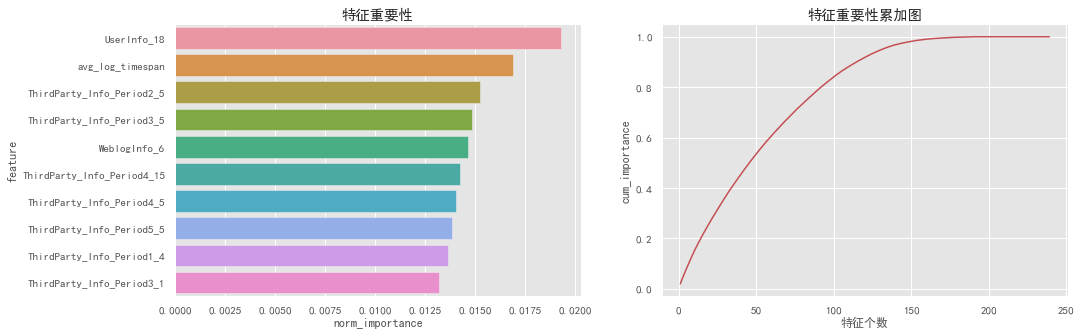

In [7]:
# 特征重要性可视化
plt.figure(figsize=(16,5))
plt.rcParams['font.sans-serif']=['SimHei']
plt.style.use('ggplot')
plt.subplot(1,2,1)
plt.title('特征重要性')
sns.barplot(data=fea_imp_df1.iloc[:10,:],x='norm_importance',y='feature')
plt.subplot(1,2,2)
plt.title('特征重要性累加图')
plt.xlabel('特征个数')
plt.ylabel('cum_importance')
plt.plot(list(range(1, len(fea_names)+1)),fea_imp_df1['cum_importance'], 'r-')
plt.show()

In [8]:
# 剔除特征重要性为0的变量
zero_imp_col = list(fea_imp_df1[fea_imp_df1.fea_importance==0].feature)
fea_imp_df11 = fea_imp_df1[~(fea_imp_df1.feature.isin(zero_imp_col))]
print('特征重要性为0的变量个数为 ：{}'.format(len(zero_imp_col)))
print(zero_imp_col)

特征重要性为0的变量个数为 ：50
['_position', 'SocialNetwork_17', '_nickname', '_orderid', '_otherwebshoptype', '_phone', '_phonetype', '_secondemail', '_ppdaiaccount', '_provinceid', '_schoolname', 'SocialNetwork_12', '_relationshipid', '_webshopurl', '_residencetypeid', '_webshoptypeid', '_userid', '_secondmobile', 'is_jilin_userinfo7', 'is_zibo_UserInfo8', 'china_mobile', '_idaddress', 'is_zibo_UserInfo20', 'WeblogInfo_19_E', 'WeblogInfo_19_G', 'WeblogInfo_19_H', 'WeblogInfo_19_J', 'WeblogInfo_21_B', 'WeblogInfo_21_C', 'WeblogInfo_21_D', '_age', '_bussinessaddress', '_byuserid', '_cityid', '_companysizeid', '_companytypeid', '_contactid', '_creationdate', '_department', '_dormitoryphone', 'china_telecom', '_flag_uctobcp', '_flag_uctopvr', '_gender', '_graduatedate', '_graduateschool', '_hasbuycar', '_hasppdaiaccount', '_hassborgjj', '_hasbusinesslicense']


In [9]:
# 剔除特征重要性比较弱的变量
low_imp_col = list(fea_imp_df11[fea_imp_df11.cum_importance>=0.99].feature)
print('特征重要性比较弱的变量个数为：{}'.format(len(low_imp_col)))
print(low_imp_col)

特征重要性比较弱的变量个数为：30
['WeblogInfo_33', '中国电信 ', 'is_zibo_UserInfo4', 'WeblogInfo_27', '_companyname', '_companyaddress', 'china_unicom', '_residenceaddress', '_districtid', 'is_jilin_userinfo19', 'is_sichuan_userinfo7', 'UserInfo_13', '_idnumber', 'is_chengdu_UserInfo20', '_incomefrom', '_marriagestatusid', 'is_hunan_userinfo7', '_regstepid', '_residencephone', '_residenceyears', '_iscash', 'WeblogInfo_36', 'is_yantai_UserInfo2', 'is_chengdu_UserInfo4', 'is_sichuan_userinfo19', 'is_weifang_UserInfo20', 'WeblogInfo_21_A', '_workyears', '中国联通 ', 'WeblogInfo_19_D']


In [10]:
# 删除特征重要性为0和比较弱的特征
drop_imp_col = zero_imp_col+low_imp_col
mydf1 = df1.drop(drop_imp_col,axis=1)
mydf1.shape

(49101, 161)

In [11]:
# 加上训练集测试集状态，保存数据
sample_status = list(df1.sample_status)
mydf1['sample_status'] = sample_status
mydf1['Idx'] = data_idx
mydf1.to_csv(path+'/feature_select_data1.csv',encoding='gb18030',index=False)